# Import the necessary libraries

In [71]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import os
import sys
import cv2

# Function to initialise the mean and variance images

In [72]:
def initBackground(initImage):
    img_arr = mpimg.imread(initImage)
    mean = img_arr
    variance = 9*np.ones(img_arr.shape)
    return(mean,variance)

# Classify images into foreground and background pixels using a Chebyshev inequality based classifier

In [73]:
def ForegroundDetection(img_file,mean,variance,lmda):
    img = cv2.imread(img_file) 
    d = img - mean
    y = variance*(lmda**2)
    d_2 = np.square(d)
    I = d_2 - y
    mask = np.all(I>0,axis=2)
    rI = 255*mask.astype(int)
    rI = rI.astype(np.uint8)
    return(rI)

# Reduce the image noise using a voting scheme

In [75]:
def Voting(rI,eta,m,n):
    r,c = rI.shape
    cI = np.zeros((rI.shape[0],rI.shape[1]))
    for i in range(m,r-1-m):
        for j in range(n,c-1-n):
            img_patch = rI[i-m:i,j-n:j]
            y_unq, counts = np.unique(img_patch,return_counts=True)
            if len(counts) == 1 and y_unq[0] == 1:
                cI[i,j] = 255
            if len(counts)>1:
                if counts[1] > eta*m*n:
                    cI[i,j] = 255
    cI = cI.astype(np.uint8)
    return cI

# Update the mean and variance images using a weighted average scheme

In [76]:
def meanvarUpdate(cI,img_path,M,V,alpha):
    img = mpimg.imread(img_path)
    mean_upd = np.zeros(img.shape)
    var_upd = np.zeros(img.shape)
    d = img - M
    d_2 = np.square(d)
    for i in range(cI.shape[0]):
        for j in range(cI.shape[1]):
            if cI[i,j] == 0:
                mean_upd[i,j,:] = (1-alpha)*M[i,j,:] + alpha*img[i,j,:]
                var_upd[i,j,:] = (1-alpha)*(V[i,j,:] + alpha*d_2[i,j,:])
                var_upd[i,j,:] = np.clip(var_upd[i,j,:],a_min = 9,a_max = None)
    return(mean_upd,var_upd)

In [77]:
def Background_Subtraction(img_dir,lmda,eta,m,n,alpha):
    
    img_file_name = os.listdir(img_dir)
    initImage = os.path.join(img_dir,img_file_name[0])
    mean, variance = initBackground(initImage)
    
    for i in range(1,19):
        img_path = os.path.join(img_dir,img_file_name[i])
        
        fig, ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_path,mean,variance,lmda)
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        mean, variance = meanvarUpdate(cI,img_path,mean,variance,alpha)
        ax[1].imshow(cI,cmap="gray")
        
        img = cv2.imread(img_path)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()
    return(mean,variance)

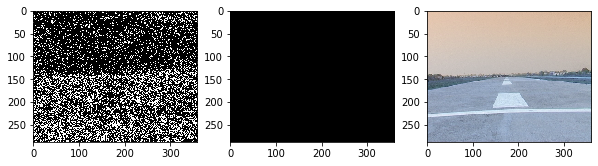

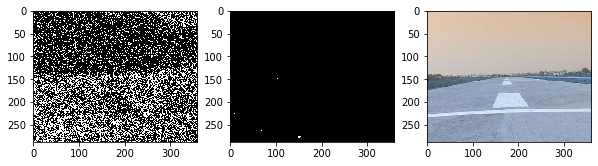

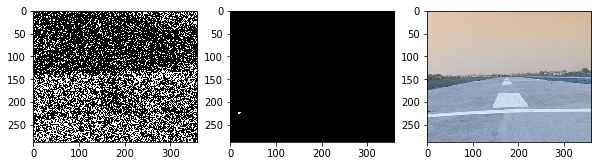

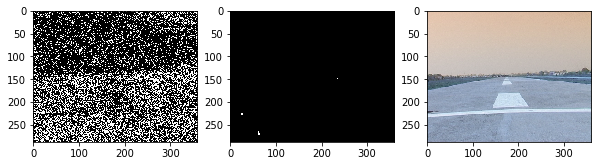

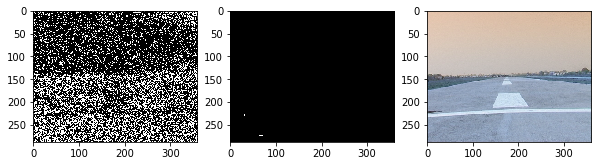

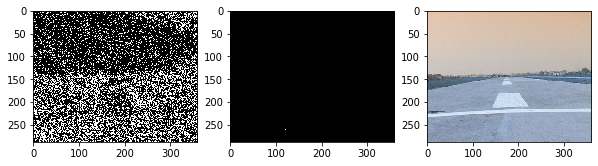

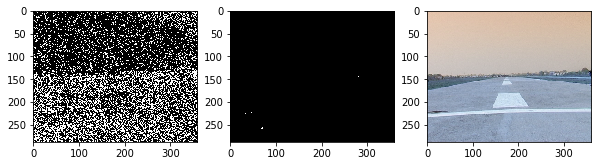

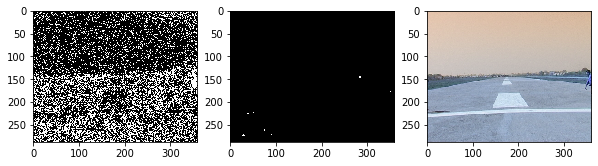

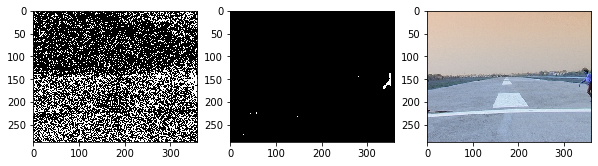

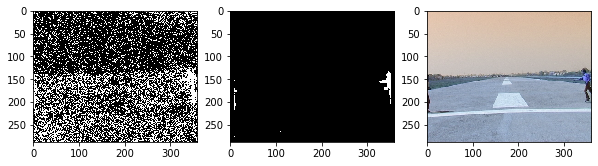

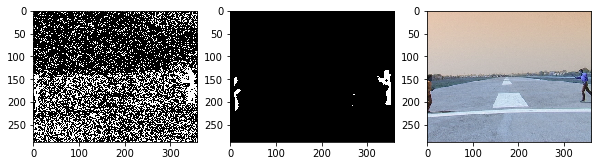

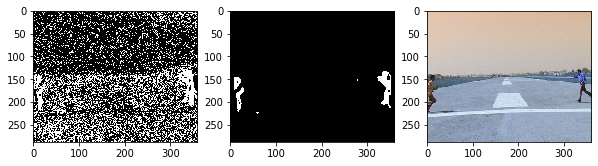

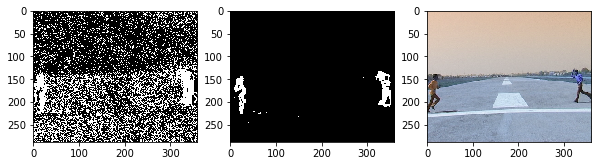

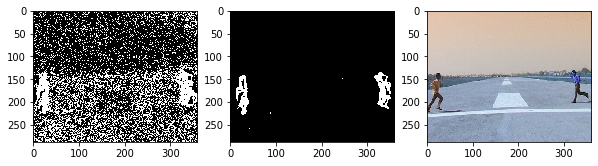

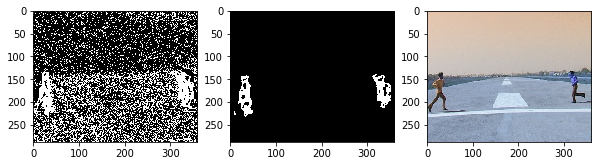

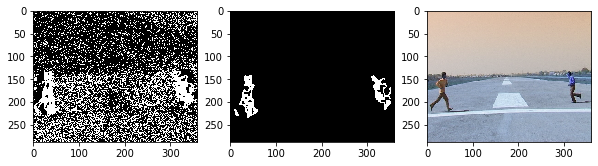

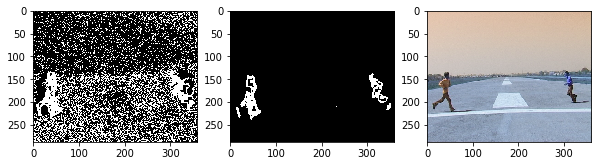

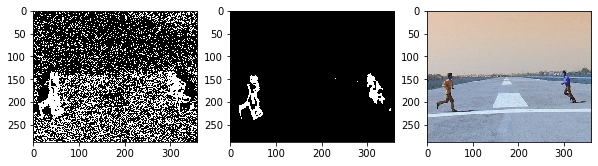

In [78]:
mean,variance = Background_Subtraction("./Images",0.8,0.7,8,8,0.8)

In [79]:
def Background_Subtraction_var_lambda(img_file,lmda_arr,eta,m,n,alpha,mean,variance,truth):
    img_ls = []
    for i in range(len(lmda_arr)):
        fig, ax = plt.subplots(1,3,figsize=(10,10))
        rI = ForegroundDetection(img_file,mean,variance,lmda_arr[i])
        ax[0].imshow(rI,cmap="gray")
        
        cI = Voting(rI,eta,m,n)
        img_ls.append(cI)
        ax[1].imshow(cI,cmap="gray")
        
        img = cv2.imread(truth)
        ax[2].imshow(img,cmap="gray")
        
        plt.show()
    return(img_ls)

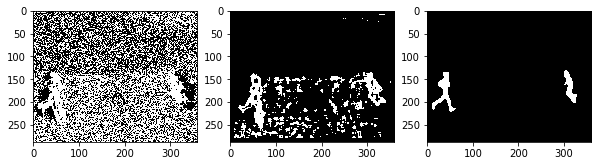

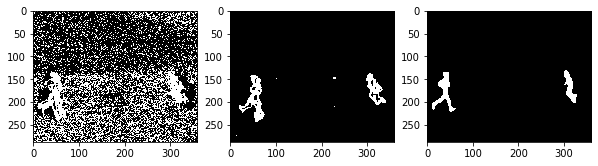

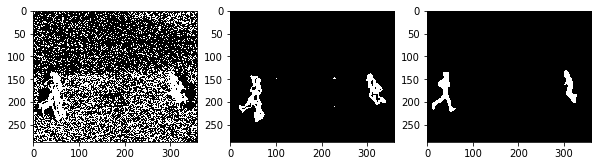

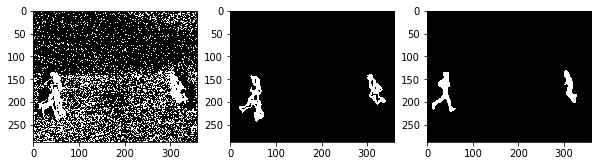

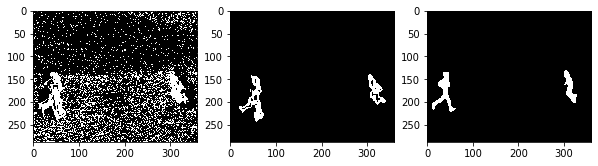

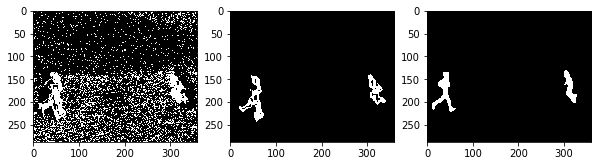

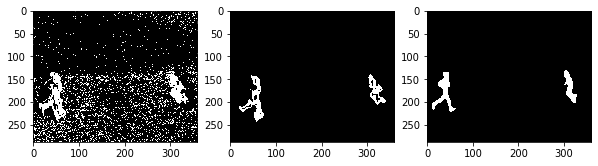

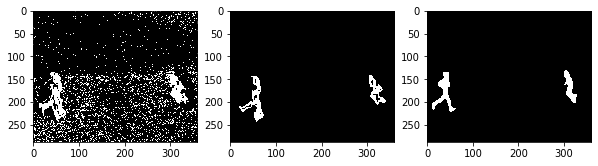

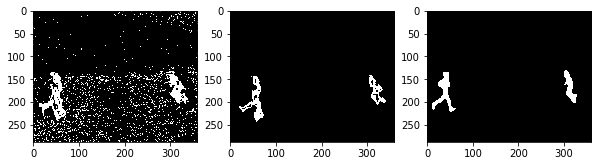

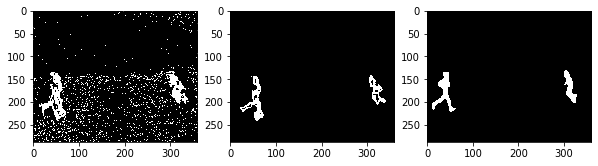

In [80]:
img_file = "./Images/AirstripRunAroundFeb2006_1317.bmp"
truth = "./BackSubGroundTruth/groundMono1317.bmp"
lmda_arr = np.linspace(0.5,1.5,10)
img_ls = Background_Subtraction_var_lambda(img_file,lmda_arr,0.7,8,8,0.8,mean,variance,truth)

In [57]:
def binary_metrics(y_true,y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == 255 and y_pred[i] == 255:
            TP += 1
        if y_true[i] == 0 and y_pred[i] == 0:
            TN += 1
        if y_true[i] == 0 and y_pred[i] == 255:
            FP += 1
        if y_true[i] == 255 and y_pred[i] == 0:
            FN += 1
    FPR = FP/(FP+TN)
    TPR = TP/(TP+FN)
    return(FPR,TPR)

In [81]:
truth_file = "./BackSubGroundTruth/groundMono1317.bmp"
gnd_truth = cv2.imread(truth_file)
print(gnd_truth.shape)

(288, 360, 3)


In [82]:
truth_file = "./BackSubGroundTruth/groundMono1317.bmp"
gnd_truth = cv2.imread(truth_file)
gnd_truth = gnd_truth[:,:,0]
gnd_truth_arr = gnd_truth.flatten()
#print(len(gnd_truth_arr))
TPR_ls = []
FPR_ls = []

for img in img_ls:
    img_arr = img.flatten()
    #print(len(img_arr))
    FPR,TPR = binary_metrics(gnd_truth_arr,img_arr)
    FPR_ls.append(FPR)
    TPR_ls.append(TPR)

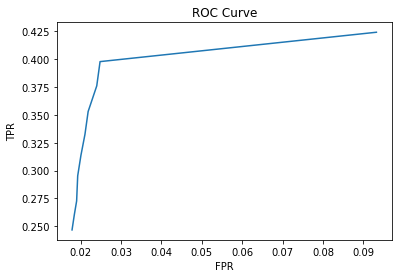

In [83]:
plt.plot(FPR_ls,TPR_ls)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()